Load external packages

In [1]:
from typing import Union, Tuple
from enum import Enum
from pathlib import Path

import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

%matplotlib inline

from albumentations import (
    Compose,
    Transpose,
    RandomRotate90,
    OneOf,
    RGBShift,
    HueSaturationValue
)

from settings.label import BinLabel, SizeLabel
from preprocess.labeling import to_cls_map, to_cls_branch_maps

Using TensorFlow backend.


Create two instances with the same arguments

In [2]:
data_gen_args = dict(horizontal_flip=True, vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
gt_datagen = ImageDataGenerator(**data_gen_args)

Provide the same seed and keyword arguments to the fit and flow methods

In [3]:
seed = 31
image_generator = image_datagen.flow_from_directory(
    '/root/input/train_sizelabel_1024/train/image',
    class_mode=None,
    seed=seed)

gt_generator = gt_datagen.flow_from_directory(
    '/root/input/train_sizelabel_1024/train/gt',
    class_mode=None,
    seed=seed)

Found 6800 images belonging to 1 classes.
Found 6800 images belonging to 1 classes.


Transform image for augmentation

In [4]:
_augmentor = Compose([
    OneOf([
        Transpose(p=0.5),
        RandomRotate90(p=0.5)
    ], p=0.5),
    OneOf([
        RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
        HueSaturationValue(hue_shift_limit=5, sat_shift_limit=1, val_shift_limit=0)
    ], p=1.0)
])

def _aug_transform(
    img_batch: np.ndarray, gt_batch: np.ndarray, label: Union[BinLabel, SizeLabel], branched: bool = False
) -> (np.ndarray, np.ndarray):
    batch_auged = (_augmentor(image=img.astype(np.uint8), mask=gt) for img, gt in zip(img_batch, gt_batch))
    # zip(*list_of_list) transposes list of list
    imgs_auged, gts_auged = zip(
        *([auged['image'] / 255., auged['mask'].astype(np.uint8)] for auged in batch_auged)
    )
    if branched:
        gts_auged_list = zip(
            *([to_categorical(branch_map, num_classes=2) for branch_map in to_cls_branch_maps(gt_auged, label)] 
            for gt_auged in gts_auged)
        )
        return np.stack(imgs_auged), [np.stack(gts_auged) for gts_auged in gts_auged_list]
    else:
        gts_auged = [to_categorical(to_cls_map(gt_auged, label), num_classes=len(label)) for gt_auged in gts_auged]
        return np.stack(imgs_auged), np.stack(gts_auged)

Combine generators into one which yields image and masks

In [5]:
train_generator = (_aug_transform(img_batch, gt_batch, SizeLabel, True) 
                   for img_batch, gt_batch in zip(image_generator, gt_generator))

To test combined train_generator, check images in batch on figure

In [6]:
def visualize(image: np.ndarray, mask: Union[np.ndarray, Tuple]):
    fontsize = 18
    plt.figure()
    if isinstance(mask, np.ndarray):
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow((image * 255.).astype(np.uint8))
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow((image * 255.).astype(np.uint8))
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(mask[0][:,:,1].astype(np.uint8))
        ax[1, 0].set_title('small mask', fontsize=fontsize)
        
        ax[0, 1].imshow(mask[1][:,:,1].astype(np.uint8))
        ax[0, 1].set_title('medium mask', fontsize=fontsize)
        
        ax[1, 1].imshow(mask[2][:,:,1].astype(np.uint8))
        ax[1, 1].set_title('large mask', fontsize=fontsize)

In [7]:
images, gts_list = next(train_generator)

<Figure size 432x288 with 0 Axes>

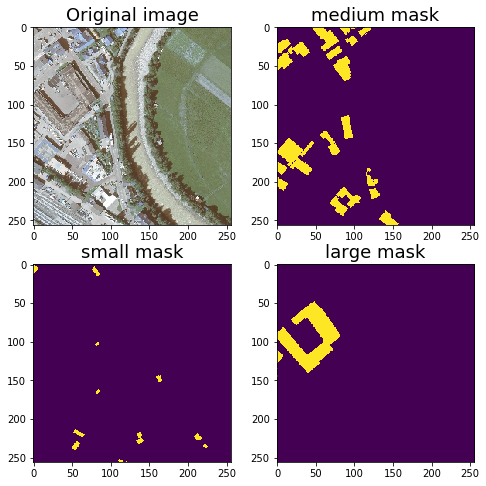

In [9]:
image_idx = 1
visualize(images[image_idx], list(zip(*gts_list))[image_idx])